In [30]:
import requests
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import argparse
import pandas as pd
import requests
import math
from io import StringIO
import warnings
import logging
import pathlib
import shutil
import geopandas as gpd
import contextily as ctx
from glob import glob
import matplotlib.pyplot as plt

In [24]:
input_shapefile_dir = '../data/shapefiles'
input_file = '../data/state_county/ar_ashley.csv.xz'

In [25]:
lat_lon_df = pd.read_csv(input_file)
lat_lon_df

,state,county,zip,longitude,latitude,address,id
0,ar,ashley,71635,-91.963568,33.123666,"301 west 9th avenue,crossett,ar,71635",ar_ashley
1,ar,ashley,71635,-91.949543,33.121913,"1100 camp road,crossett,ar,71635",ar_ashley
2,ar,ashley,71635,-91.950245,33.121784,"1100 camp road,crossett,ar,71635",ar_ashley
3,ar,ashley,71635,-91.949614,33.118393,"1300 pecan street,crossett,ar,71635",ar_ashley
4,ar,ashley,71635,-91.960783,33.126432,"701 main street,crossett,ar,71635",ar_ashley
...,...,...,...,...,...,...,...
12985,ar,ashley,71661,-91.616955,33.122743,"433 ashley 351 road,parkdale,ar,71661",ar_ashley
12986,ar,ashley,71661,-91.484689,33.127085,"381 ashley 45 road,parkdale,ar,71661",ar_ashley
12987,ar,ashley,71646,-91.748783,33.269232,"521 ashley 70 road,hamburg,ar,71646",ar_ashley
12988,ar,ashley,71635,-92.043261,33.116475,"118 pinewood road,crossett,ar,71635",ar_ashley


In [4]:
state_fip = '02'
state_shape_files = [v for v in os.listdir(input_shapefile_dir) if (v.split('.')[-1]=='zip' and v.split('_')[2][:2]==state_fip)]
state_shape_files

['tl_2020_02185_tabblock20.zip',
 'tl_2020_02240_tabblock20.zip',
 'tl_2020_02198_tabblock20.zip',
 'tl_2020_02063_tabblock20.zip',
 'tl_2020_02013_tabblock20.zip',
 'tl_2020_02105_tabblock20.zip',
 'tl_2020_02110_tabblock20.zip',
 'tl_2020_02070_tabblock20.zip',
 'tl_2020_02230_tabblock20.zip',
 'tl_2020_02164_tabblock20.zip',
 'tl_2020_02016_tabblock20.zip',
 'tl_2020_02100_tabblock20.zip',
 'tl_2020_02090_tabblock20.zip',
 'tl_2020_02060_tabblock20.zip',
 'tl_2020_02068_tabblock20.zip',
 'tl_2020_02220_tabblock20.zip',
 'tl_2020_02180_tabblock20.zip',
 'tl_2020_02195_tabblock20.zip',
 'tl_2020_02188_tabblock20.zip',
 'tl_2020_02170_tabblock20.zip',
 'tl_2020_02066_tabblock20.zip',
 'tl_2020_02150_tabblock20.zip',
 'tl_2020_02158_tabblock20.zip',
 'tl_2020_02020_tabblock20.zip',
 'tl_2020_02282_tabblock20.zip',
 'tl_2020_02275_tabblock20.zip',
 'tl_2020_02290_tabblock20.zip',
 'tl_2020_02130_tabblock20.zip',
 'tl_2020_02122_tabblock20.zip',
 'tl_2020_02050_tabblock20.zip']

In [22]:
def main(
    state_fip, 
    lat_lon_df,
    input_shapefile_dir,
):
    warnings.filterwarnings("ignore")    
    
    state_shape_files = [v for v in os.listdir(input_shapefile_dir) if (v.split('.')[-1]=='zip' and v.split('_')[2][:2]==state_fip)]
    pbar =  tqdm(state_shape_files)
    for sf in pbar:
        pbar.set_description('Parsing: %s' % sf)
        shapefile_path = os.path.join(input_shapefile_dir, sf)
        state_df = gpd.read_file(shapefile_path)

#         test_df = state_df.sjoin(lat_lon_df.sample(3), how="inner", predicate="intersects")
#         print(test_df)
#         if not len(lat_lon_df) > 0: # if fail the test, skip it
#             pbar.set_description('Test failed for %s, skipping' % sf)
#             print(test_df)
#             input()
#             continue
        
        # Spatial join the address with points and the jeffesron county blocks with polygons
        lat_lon_df = lat_lon_df.sjoin(state_df, how="left", predicate="intersects")
        # print(lat_lon_df)
        lat_lon_df = lat_lon_df[
            ["address", "GEOID20", "longitude", "latitude", 'geometry']
        ]
        # print(isinstance(lat_lon_df, gpd.GeoDataFrame))
        lat_lon_df = lat_lon_df.rename(columns={"GEOID20": "geoid20"})
    return lat_lon_df

In [16]:
cgdf = gpd.GeoDataFrame(
    lat_lon_df,
    geometry=gpd.points_from_xy(lat_lon_df.longitude, lat_lon_df.latitude),
)
cgdf

,state,county,zip,longitude,latitude,address,id,geometry
0,ar,ashley,71635,-91.963568,33.123666,"301 west 9th avenue,crossett,ar,71635",ar_ashley,POINT (-91.96357 33.12367)
1,ar,ashley,71635,-91.949543,33.121913,"1100 camp road,crossett,ar,71635",ar_ashley,POINT (-91.94954 33.12191)
2,ar,ashley,71635,-91.950245,33.121784,"1100 camp road,crossett,ar,71635",ar_ashley,POINT (-91.95025 33.12178)
3,ar,ashley,71635,-91.949614,33.118393,"1300 pecan street,crossett,ar,71635",ar_ashley,POINT (-91.94961 33.11839)
4,ar,ashley,71635,-91.960783,33.126432,"701 main street,crossett,ar,71635",ar_ashley,POINT (-91.96078 33.12643)
...,...,...,...,...,...,...,...,...
12985,ar,ashley,71661,-91.616955,33.122743,"433 ashley 351 road,parkdale,ar,71661",ar_ashley,POINT (-91.61696 33.12274)
12986,ar,ashley,71661,-91.484689,33.127085,"381 ashley 45 road,parkdale,ar,71661",ar_ashley,POINT (-91.48469 33.12709)
12987,ar,ashley,71646,-91.748783,33.269232,"521 ashley 70 road,hamburg,ar,71646",ar_ashley,POINT (-91.74878 33.26923)
12988,ar,ashley,71635,-92.043261,33.116475,"118 pinewood road,crossett,ar,71635",ar_ashley,POINT (-92.04326 33.11648)


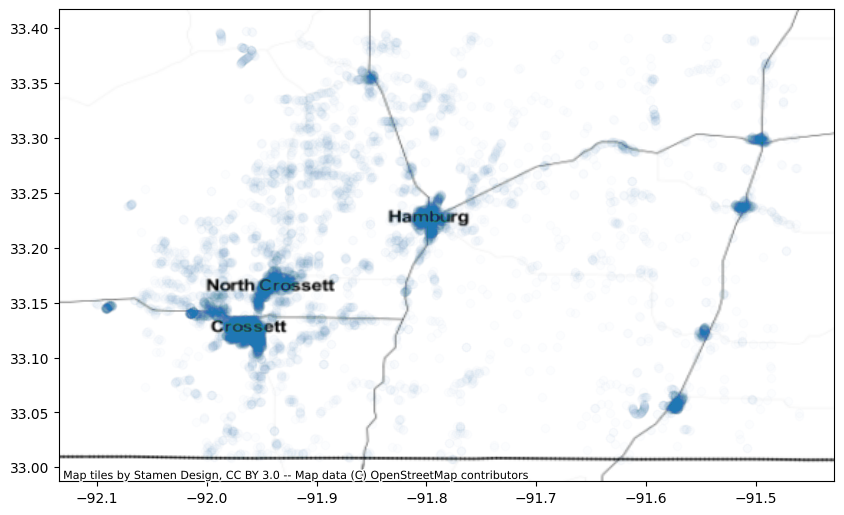

In [44]:
cgdf.crs= 4326
ax = cgdf.plot(figsize=(10, 10), alpha=0.01)
ctx.add_basemap(ax, zoom=10, crs=cgdf.crs.to_string(), source=ctx.providers.Stamen.Toner)

In [47]:
print(state_shape_files)

['tl_2020_02185_tabblock20.zip', 'tl_2020_02240_tabblock20.zip', 'tl_2020_02198_tabblock20.zip', 'tl_2020_02063_tabblock20.zip', 'tl_2020_02013_tabblock20.zip', 'tl_2020_02105_tabblock20.zip', 'tl_2020_02110_tabblock20.zip', 'tl_2020_02070_tabblock20.zip', 'tl_2020_02230_tabblock20.zip', 'tl_2020_02164_tabblock20.zip', 'tl_2020_02016_tabblock20.zip', 'tl_2020_02100_tabblock20.zip', 'tl_2020_02090_tabblock20.zip', 'tl_2020_02060_tabblock20.zip', 'tl_2020_02068_tabblock20.zip', 'tl_2020_02220_tabblock20.zip', 'tl_2020_02180_tabblock20.zip', 'tl_2020_02195_tabblock20.zip', 'tl_2020_02188_tabblock20.zip', 'tl_2020_02170_tabblock20.zip', 'tl_2020_02066_tabblock20.zip', 'tl_2020_02150_tabblock20.zip', 'tl_2020_02158_tabblock20.zip', 'tl_2020_02020_tabblock20.zip', 'tl_2020_02282_tabblock20.zip', 'tl_2020_02275_tabblock20.zip', 'tl_2020_02290_tabblock20.zip', 'tl_2020_02130_tabblock20.zip', 'tl_2020_02122_tabblock20.zip', 'tl_2020_02050_tabblock20.zip']


In [ ]:
state_df = gpd.read_file(os.path.join('../data/shapefiles', state_shape_files[0]))
state_df.crs= 4326
ax = state_df.plot(figsize=(10, 10))
ctx.add_basemap(ax, zoom=10, crs=state_df.crs.to_string(), source=ctx.providers.Stamen.Toner)

In [23]:
df = main('02', cgdf, input_shapefile_dir)
df

Parsing: tl_2020_02050_tabblock20.zip: 100%|█████████████████████████| 30/30 [00:20<00:00,  1.48it/s]


,address,geoid20,longitude,latitude,geometry
0,"301 west 9th avenue,crossett,ar,71635",NaN,-91.963568,33.123666,POINT (-91.96357 33.12367)
1,"1100 camp road,crossett,ar,71635",NaN,-91.949543,33.121913,POINT (-91.94954 33.12191)
2,"1100 camp road,crossett,ar,71635",NaN,-91.950245,33.121784,POINT (-91.95025 33.12178)
3,"1300 pecan street,crossett,ar,71635",NaN,-91.949614,33.118393,POINT (-91.94961 33.11839)
4,"701 main street,crossett,ar,71635",NaN,-91.960783,33.126432,POINT (-91.96078 33.12643)
...,...,...,...,...,...
12985,"433 ashley 351 road,parkdale,ar,71661",NaN,-91.616955,33.122743,POINT (-91.61696 33.12274)
12986,"381 ashley 45 road,parkdale,ar,71661",NaN,-91.484689,33.127085,POINT (-91.48469 33.12709)
12987,"521 ashley 70 road,hamburg,ar,71646",NaN,-91.748783,33.269232,POINT (-91.74878 33.26923)
12988,"118 pinewood road,crossett,ar,71635",NaN,-92.043261,33.116475,POINT (-92.04326 33.11648)
